# Uncertainty Analysis

In this tutorial, we will perform an uncertainty analysis using the EnergyScope model. We will explore how varying certain parameters affects the energy system configuration and results. This is achieved by generating a sequence of parameter values using Sobol sequences, running multiple optimizations, and analyzing the outcomes.

---
## Import Necessary Libraries

First, we import all the required libraries and modules:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from energyscope.energyscope import Energyscope
from energyscope.models import infrastructure_ch_2050
from energyscope.result import postprocessing
from energyscope.datasets import gen_sobol_sequence



- **`pandas`**: For data manipulation and analysis.
- **`numpy`**: For numerical operations.
- **`seaborn`**: For statistical data visualization.
- **`Energyscope`**: Main class for initializing and running the EnergyScope model.
- **`infrastructure_ch_2050`**: Predefined model for different configurations.
- **`postprocessing`**: Functions to process results after optimizations.
- **`gen_sobol_sequence`**: Function to generate Sobol sequences for parameter sampling.

---
## Manual Parameter Definition

### Define Parameters for Uncertainty Analysis

We manually define a list of parameters whose uncertainty we want to analyze. Each parameter includes a name, a lower bound, and an upper bound:

In [2]:
varying_parameter = 'c_inv'
parameters = [
    {'name': 'PV_LV', 'lower_bound': 0, 'upper_bound': 50},
    {'name': 'WIND', 'lower_bound': 0, 'upper_bound': 20},
    {'name': 'CCGT', 'lower_bound': 0, 'upper_bound': 10}
]


- **`PV_LV`**: Photovoltaic at Low Voltage level.
- **`WIND`**: Wind energy capacity.
- **`CCGT`**: Combined Cycle Gas Turbine capacity.
- The bounds represent the range within which the parameter values will vary during the analysis.

### Generate Sobol Sequence for Parameter Sampling

We use the `gen_sobol_sequence` function to generate a Sobol sequence, which provides quasi-random samples of parameter values within the specified bounds:

In [3]:
seq, prob = gen_sobol_sequence(parameters=parameters, trajectories=4)



- **`trajectories=4`**: Specifies the number of trajectories or samples to generate.
- **`seq`**: The generated sequence of parameter values.
- **`prob`**: Metadata about the parameters and their sampling.

### Display Number of Generated Samples

We can display the number of generated samples to verify:

In [4]:
display(len(seq))

20



- This should output the total number of parameter sets generated.

### Prepare Parameter DataFrame

We prepare a DataFrame to hold the generated parameter sequences in a format suitable for the EnergyScope model:

In [5]:
df = pd.DataFrame(seq, columns=prob['names']).T
df.columns = ['value' + str(x) for x in list(df.columns) if not str(x) == "nan"]
df = df.reset_index(names=['index0'])
df['param'] = varying_parameter

df['index1'] = np.nan
df['index2'] = np.nan
df['index3'] = np.nan
df

,index0,value0,value1,value2,value3,value4,value5,value6,value7,value8,...,value14,value15,value16,value17,value18,value19,param,index1,index2,index3
0,PV_LV,4.6875,32.8125,4.6875,4.6875,32.8125,29.6875,7.8125,29.6875,29.6875,...,45.3125,17.1875,20.3125,17.1875,17.1875,20.3125,c_inv,NaN,NaN,NaN
1,WIND,9.3750,9.3750,5.6250,9.3750,5.6250,19.3750,19.3750,15.6250,19.3750,...,10.6250,14.3750,14.3750,0.6250,14.3750,0.6250,c_inv,NaN,NaN,NaN
2,CCGT,4.6875,4.6875,4.6875,9.6875,9.6875,9.6875,9.6875,9.6875,4.6875,...,2.1875,7.1875,7.1875,7.1875,7.1875,7.1875,c_inv,NaN,NaN,NaN




- **Transpose the DataFrame**: To match the expected format.
- **Rename Columns**: Prefix columns with `'value'`.
- **Reset Index**: To ensure the parameters are properly indexed.
- **Add Parameter Type**: We specify that these values correspond to `'c_inv'` (investment costs).
- **Add Empty Indices**: Additional indices are added for compatibility with the model's expectations.

---
## Define Solver Options

We specify solver options to control the optimization process:

In [6]:
solver_options = {
    'solver': 'gurobi',
    'presolve_eps': 5e-9,
    'presolve_fixeps': 7e-10,
    'mipgap': 1e-10,
    'display_eps': 1e-10,
    'omit_zero_rows': 1,
    'omit_zero_cols': 1,
    'show_stats': 0,
    'solver_msg': 0,
    'cplex_options': 'integrality=5e-7',
}



- **`'solver': 'gurobi'`**: Specifies that the Gurobi solver should be used.
- Other options fine-tune the solver's precision and output behavior.

---
## Initialize and Run the Model with Parameter Variations

### Initialize the EnergyScope Model

We create an instance of the EnergyScope model using the infrastructure_ch_2050 dataset and the specified solver options:

In [7]:
es_infra_ch = Energyscope(model=infrastructure_ch_2050, solver_options=solver_options)



### Run Multiple Optimizations with Varying Parameters

We use the `calc_sequence` method to run the model multiple times, each time with a different set of parameters from the Sobol sequence:

In [8]:
results_ch_n = es_infra_ch.calc_sequence(df)

Gurobi 11.0.0:Gurobi 11.0.0:1
Gurobi 11.0.0:2
Gurobi 11.0.0:3
Gurobi 11.0.0:4
Gurobi 11.0.0:5
Gurobi 11.0.0:6
Gurobi 11.0.0:7
Gurobi 11.0.0:8
Gurobi 11.0.0:9
Gurobi 11.0.0:10
Gurobi 11.0.0:11
Gurobi 11.0.0:12
Gurobi 11.0.0:13
Gurobi 11.0.0:14
Gurobi 11.0.0:15
Gurobi 11.0.0:16
Gurobi 11.0.0:17
Gurobi 11.0.0:18
Gurobi 11.0.0:19
Gurobi 11.0.0:20


---
## Post-Process and Analyze Results

### Post-Process Results

In [9]:
# Postcompute KPIs
results_ch_n = postprocessing(results_ch_n, df_monthly=True)



- **`df_monthly=True`**: Indicates that monthly data should be included in the post-processing.

### Extract Annual Results

We extract the annual results DataFrame for further analysis:

In [10]:
df_annual = results_ch_n.postprocessing['df_annual']
df_annual = df_annual.loc[:, ['F_Mult']]
df_annual = df_annual.reset_index()



- **`F_Mult`**: Represents the flow multipliers or capacities of technologies.

### Pivot the Results DataFrame

We pivot the DataFrame to have technologies as columns and runs as rows:

In [11]:
df_annual = pd.pivot_table(df_annual, values='F_Mult', index=['Run'], columns='level_0')
df_annual.sample(5)

level_0,ALKALINE_ELECTROLYSIS,AL_MAKING,AL_MAKING_HR,AN_DIG,AN_DIG_SI,BATTERY,BIOGAS_BIOMETHANE,BIOMASS_ETHANOL,BUS_CNG_STOICH,BUS_DIESEL,...,TRAIN_NG,TRAMWAY,TRUCK,TRUCK_CO2,TRUCK_EV,TRUCK_FC,TRUCK_SNG,UNMINEABLE_COAL_SEAM,WIND,WOOD_METHANOL
Run,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.425481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.390099,0.0,0.0,0.611416,0.0,0.0,0.0,20.0,0.0
14,0.0,0.0,0.0,0.425481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.390099,0.0,0.0,0.611416,0.0,0.0,0.0,20.0,0.0
15,0.0,0.0,0.0,0.425481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.390099,0.0,0.0,0.611416,0.0,0.0,0.0,20.0,0.0
1,0.0,0.0,0.0,0.425481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.390099,0.0,0.0,0.611416,0.0,0.0,0.0,20.0,0.0
20,0.0,0.0,0.0,0.425481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.390099,0.0,0.0,0.611416,0.0,0.0,0.0,20.0,0.0




- This format is suitable for statistical analysis and visualization.

---
## Visualize Technology Distribution

### Plot Pairwise Relationships

We use Seaborn's `pairplot` function to visualize pairwise relationships between the capacities of different technologies:

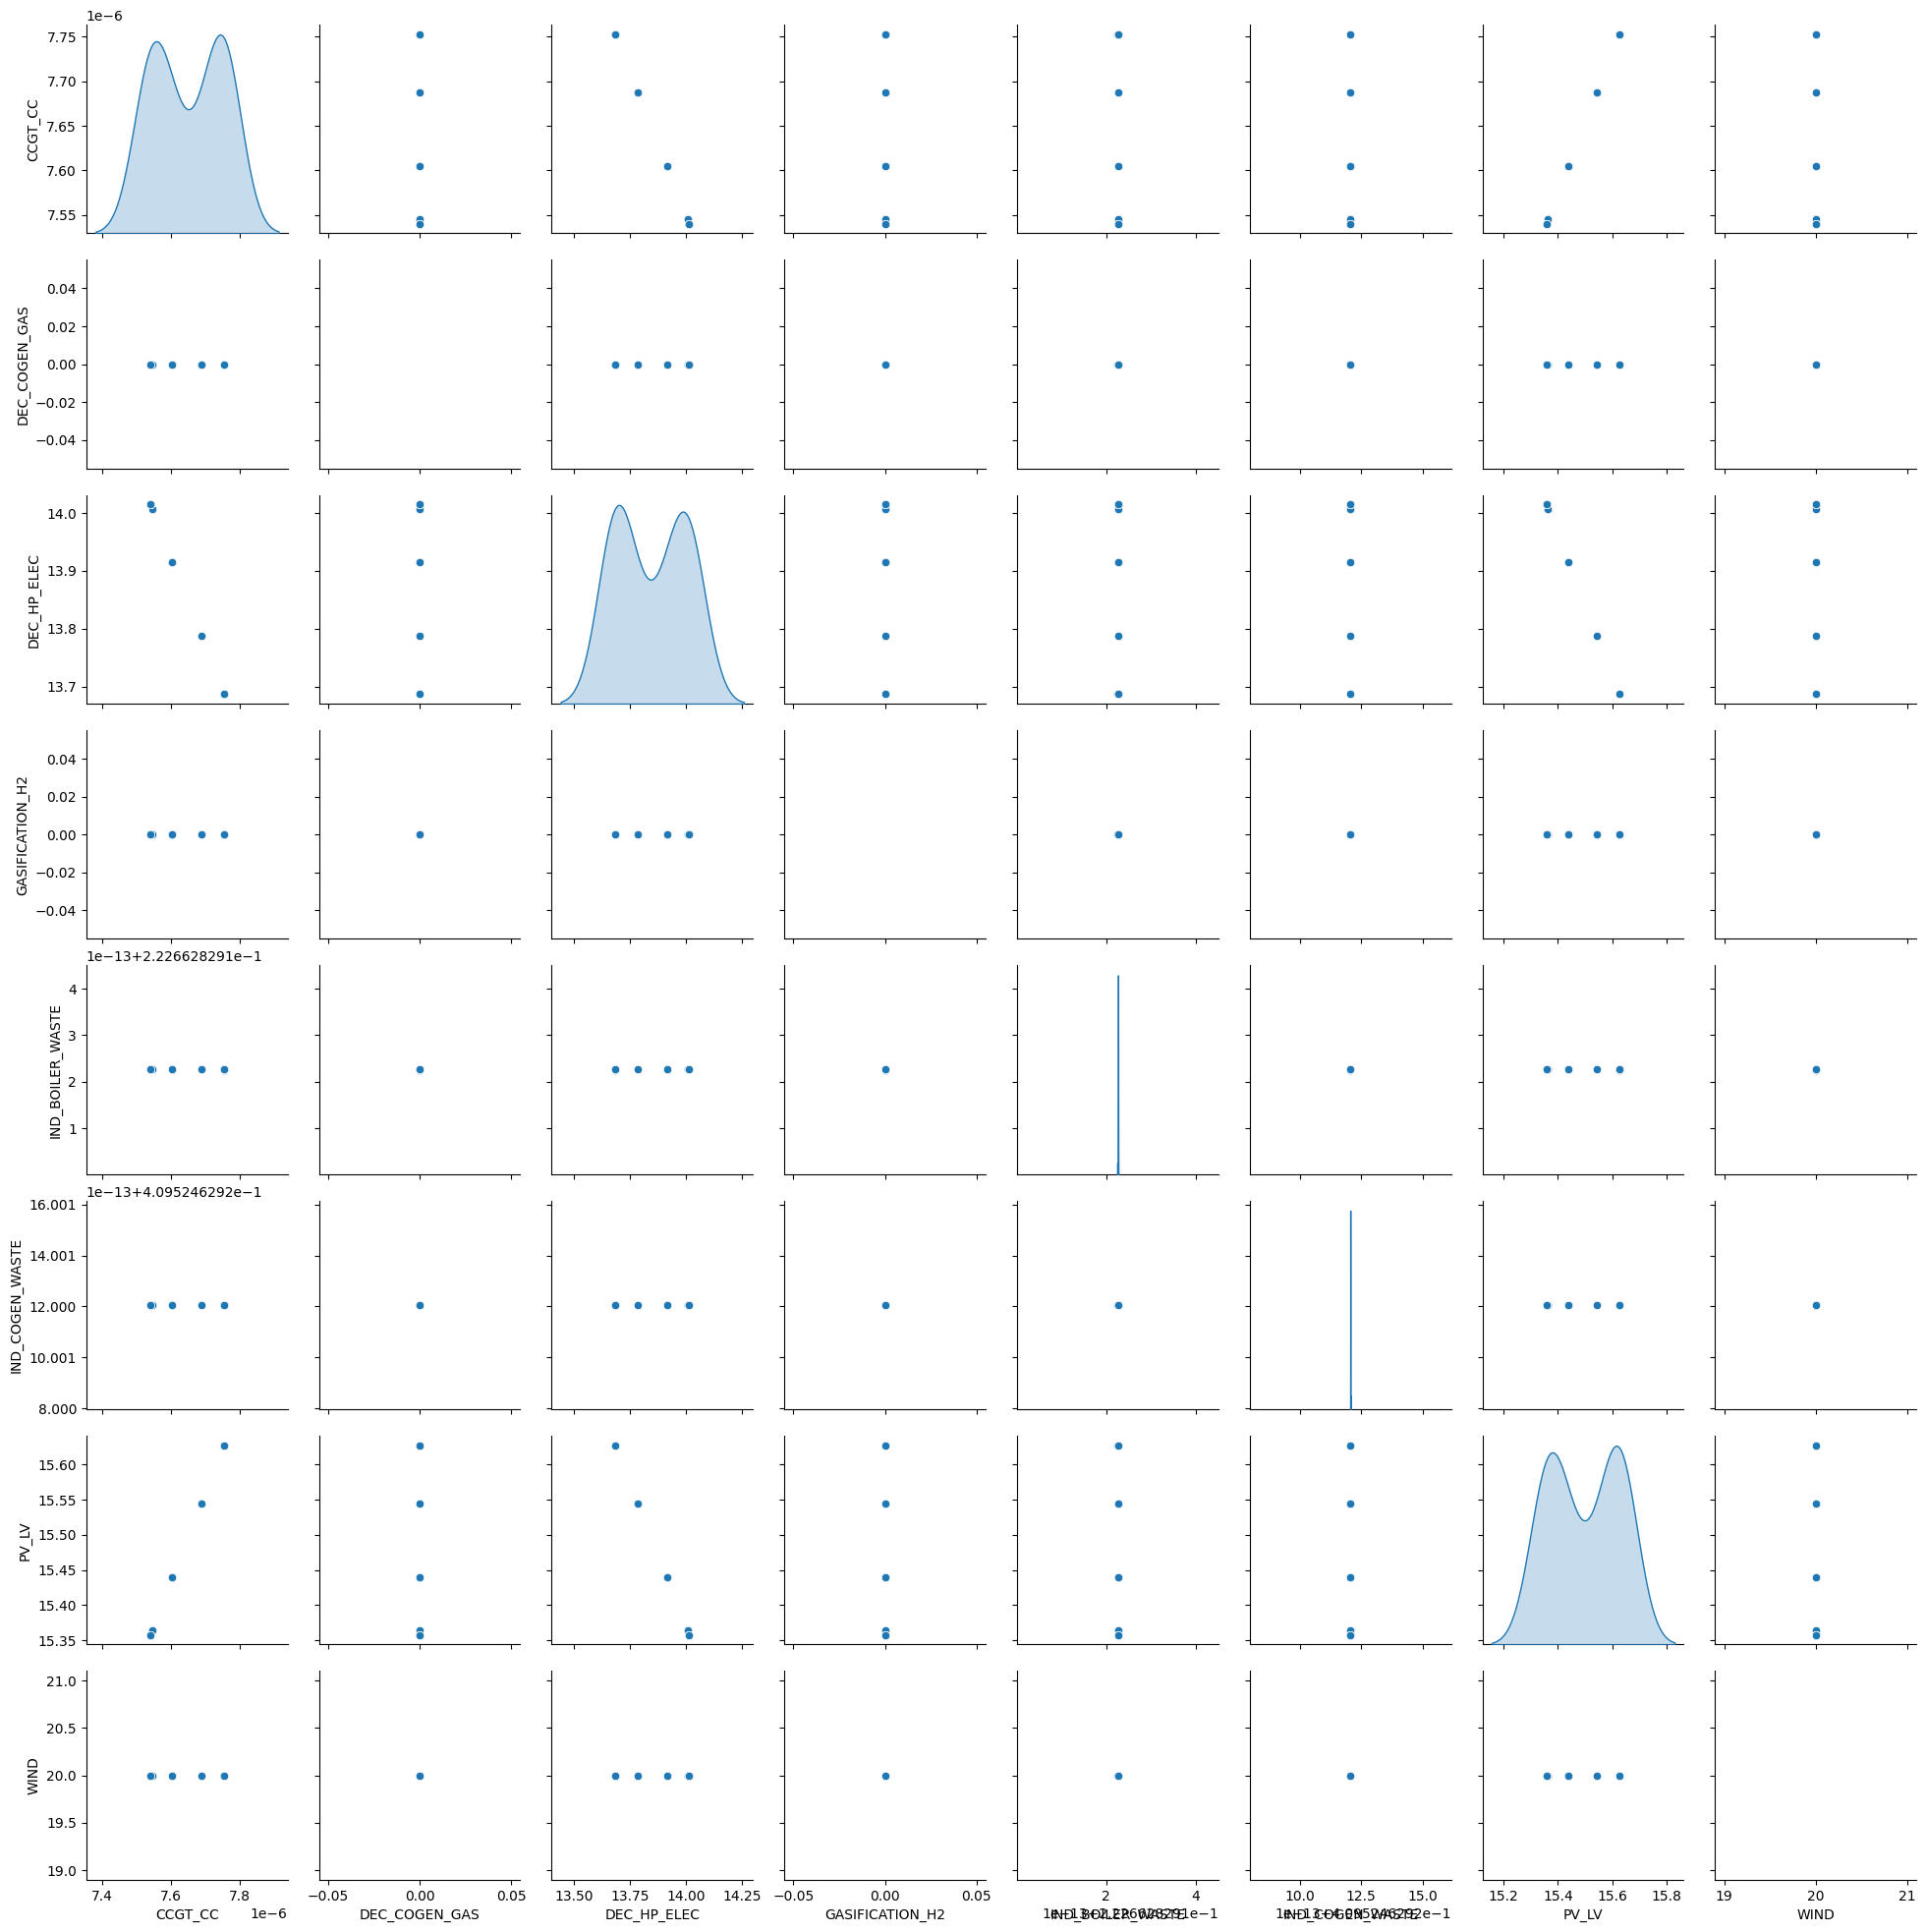

In [12]:
cols = ['CCGT_CC', 'DEC_COGEN_GAS', 'DEC_HP_ELEC', 'GASIFICATION_H2', 'IND_BOILER_WASTE', 'IND_COGEN_WASTE', 'PV_LV', 'WIND']
sns.pairplot(df_annual[cols].fillna(0), diag_kind="kde")



- **`cols`**: List of technologies to include in the plot.
- **`fillna(0)`**: Replaces NaN values with zero for plotting purposes.
- **`diag_kind="kde"`**: Uses Kernel Density Estimation for the diagonal plots.

---
## Semi-Automated Sequence Creation

In this section, we automate the generation of parameter sequences based on existing model parameters.

### Initialize the Model

We initialize the EnergyScope model again:

In [13]:
es_infra_ch = Energyscope(model=infrastructure_ch_2050)



### Run the Base Model

We perform an initial calculation to obtain baseline parameter values:

In [14]:
# Solve the model
results_ch = es_infra_ch.calc()

Gurobi 11.0.0:Gurobi 11.0.0: optimal solution; objective 8151.373244
6079 simplex iteration(s)
1 branching node(s)
absmipgap=0.102405, relmipgap=1.25629e-05




### Extract and Adjust Investment Costs

We extract the investment costs (`c_inv`) from the model parameters and define new bounds for uncertainty analysis:

In [15]:
c_inv = results_ch.parameters['c_inv'].drop('Run', axis=1)
c_inv['lower_bound'] = 0.5 * c_inv['c_inv']
c_inv['upper_bound'] = 1.5 * c_inv['c_inv']
c_inv = c_inv.reset_index(names=['name']).drop('c_inv', axis=1)
c_inv = c_inv.loc[c_inv['lower_bound'] != 0, :]



- **Adjust Bounds**: We set the lower and upper bounds to ±50% of the original investment costs.
- **Filter Out Zero Costs**: Remove parameters where the lower bound is zero.

### Select Key Technologies

Due to computational limitations, we select a subset of technologies to include in the uncertainty analysis:

In [16]:
selected_technologies = ['PV_LV', 'PV_MV', 'PV_HV', 'PV_EHV', 'DEC_HP_ELEC', 'WIND', 'GASIFICATION_H2', 'GASIFICATION_SNG']
c_inv = c_inv.loc[c_inv['name'].isin(selected_technologies), :]



- **`selected_technologies`**: List of technologies chosen for analysis.

### Convert Parameters to Dictionary Format

We convert the DataFrame of parameters to a list of dictionaries required by the `gen_sobol_sequence` function:

In [17]:
c_inv = c_inv.to_dict(orient='records')



### Generate Sobol Sequence for Selected Parameters

We generate a Sobol sequence for the selected parameters:

In [18]:
seq, prob = gen_sobol_sequence(parameters=c_inv, trajectories=8)



- **`trajectories=8`**: Generates more samples for a more detailed analysis.

### Display Number of Generated Samples

In [19]:
display(len(seq))

80



### Prepare Parameter DataFrame

We prepare the DataFrame for the new sequence:

In [20]:
df = pd.DataFrame(seq, columns=prob['names']).T
df.columns = ['value' + str(x) for x in list(df.columns) if not str(x) == "nan"]
df = df.reset_index(names=['index0'])
df['param'] = 'c_inv'

df['index1'] = np.nan
df['index2'] = np.nan
df['index3'] = np.nan
df

,index0,value0,value1,value2,value3,value4,value5,value6,value7,value8,...,value74,value75,value76,value77,value78,value79,param,index1,index2,index3
0,DEC_HP_ELEC,311.985938,509.029688,311.985938,311.985938,311.985938,311.985938,311.985938,311.985938,311.985938,...,377.667188,377.667188,377.667188,377.667188,377.667188,706.073438,c_inv,NaN,NaN,NaN
1,GASIFICATION_H2,1383.181250,1383.181250,936.993750,1383.181250,1383.181250,1383.181250,1383.181250,1383.181250,1383.181250,...,1918.606250,1918.606250,1918.606250,1918.606250,1918.606250,1829.368750,c_inv,NaN,NaN,NaN
2,GASIFICATION_SNG,2838.544063,2838.544063,2838.544063,1739.752812,2838.544063,2838.544063,2838.544063,2838.544063,2838.544063,...,1739.752812,1739.752812,1739.752812,1739.752812,1739.752812,3571.071563,c_inv,NaN,NaN,NaN
3,PV_EHV,1503.125000,1503.125000,1503.125000,1503.125000,1178.125000,1503.125000,1503.125000,1503.125000,1503.125000,...,1015.625000,1340.625000,1340.625000,1340.625000,1340.625000,1015.625000,c_inv,NaN,NaN,NaN
4,PV_HV,367.187500,367.187500,367.187500,367.187500,367.187500,543.437500,367.187500,367.187500,367.187500,...,425.937500,249.687500,425.937500,425.937500,425.937500,249.687500,c_inv,NaN,NaN,NaN
5,PV_LV,954.687500,954.687500,954.687500,954.687500,954.687500,954.687500,751.562500,954.687500,954.687500,...,710.937500,710.937500,832.812500,710.937500,710.937500,832.812500,c_inv,NaN,NaN,NaN
6,PV_MV,629.062500,629.062500,629.062500,629.062500,629.062500,629.062500,629.062500,514.687500,629.062500,...,400.312500,400.312500,400.312500,590.937500,400.312500,590.937500,c_inv,NaN,NaN,NaN
7,WIND,1969.426875,1969.426875,1969.426875,1969.426875,1969.426875,1969.426875,1969.426875,1969.426875,778.610625,...,1419.819375,1419.819375,1419.819375,1419.819375,961.813125,961.813125,c_inv,NaN,NaN,NaN


---

## Run Optimizations with New Parameter Sets

### Define Solver Options

We define the solver options again (same as before):

In [21]:
solver_options = {
    'solver': 'gurobi',
    'presolve_eps': 5e-9,
    'presolve_fixeps': 7e-10,
    'mipgap': 1e-10,
    'display_eps': 1e-10,
    'omit_zero_rows': 1,
    'omit_zero_cols': 1,
    'show_stats': 0,
    'solver_msg': 0,
    'cplex_options': 'integrality=5e-7',
}



### Initialize the Model with Solver Options

In [22]:
es_infra_ch = Energyscope(model=infrastructure_ch_2050, solver_options=solver_options)



### Run Multiple Optimizations

We run the model multiple times with the new parameter sets:

In [23]:
results_ch_n = es_infra_ch.calc_sequence(df)

Gurobi 11.0.0:Gurobi 11.0.0:1
Gurobi 11.0.0:2
Gurobi 11.0.0:3
Gurobi 11.0.0:4
Gurobi 11.0.0:5
Gurobi 11.0.0:6
Gurobi 11.0.0:7
Gurobi 11.0.0:8
Gurobi 11.0.0:9
Gurobi 11.0.0:10
Gurobi 11.0.0:11
Gurobi 11.0.0:12
Gurobi 11.0.0:13
Gurobi 11.0.0:14
Gurobi 11.0.0:15
Gurobi 11.0.0:16
Gurobi 11.0.0:17
Gurobi 11.0.0:18
Gurobi 11.0.0:19
Gurobi 11.0.0:20
Gurobi 11.0.0:21
Gurobi 11.0.0:22
Gurobi 11.0.0:23
Gurobi 11.0.0:24
Gurobi 11.0.0:25
Gurobi 11.0.0:26
Gurobi 11.0.0:27
Gurobi 11.0.0:28
Gurobi 11.0.0:29
Gurobi 11.0.0:30
Gurobi 11.0.0:31
Gurobi 11.0.0:32
Gurobi 11.0.0:33
Gurobi 11.0.0:34
Gurobi 11.0.0:35
Gurobi 11.0.0:36
Gurobi 11.0.0:37
Gurobi 11.0.0:38
Gurobi 11.0.0:39
Gurobi 11.0.0:40
Gurobi 11.0.0:41
Gurobi 11.0.0:42
Gurobi 11.0.0:43
Gurobi 11.0.0:44
Gurobi 11.0.0:45
Gurobi 11.0.0:46
Gurobi 11.0.0:47
Gurobi 11.0.0:48
Gurobi 11.0.0:49
Gurobi 11.0.0:50
Gurobi 11.0.0:51
Gurobi 11.0.0:52
Gurobi 11.0.0:53
Gurobi 11.0.0:54
Gurobi 11.0.0:55
Gurobi 11.0.0:56
Gurobi 11.0.0:57
Gurobi 11.0.0:58
Gurobi 11


---

## Post-Process and Analyze Results

### Post-Process Results

In [24]:
# Postcompute KPIs
results_ch_n = postprocessing(results_ch_n, df_monthly=False)



- **`df_monthly=False`**: We are focusing on annual data in this case.

### Extract and Prepare Annual Results

In [25]:
df_annual = results_ch_n.postprocessing['df_annual']
df_annual = df_annual.loc[:, ['F_Mult']]
df_annual = df_annual.reset_index()

df_annual = pd.pivot_table(df_annual, values='F_Mult', index=['Run'], columns='level_0')
df_annual.sample(5)

level_0,ALKALINE_ELECTROLYSIS,AL_MAKING,AL_MAKING_HR,AN_DIG,AN_DIG_SI,BATTERY,BIOGAS_BIOMETHANE,BIOMASS_ETHANOL,BUS_CNG_STOICH,BUS_DIESEL,...,TRAIN_NG,TRAMWAY,TRUCK,TRUCK_CO2,TRUCK_EV,TRUCK_FC,TRUCK_SNG,UNMINEABLE_COAL_SEAM,WIND,WOOD_METHANOL
Run,,,,,,,,,,,,,,,,,,,,,
32,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.611416,0.0,0.0,0.0,4.258822,0.0
43,0.0,0.0,0.0,0.425481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.390099,0.0,0.0,0.611416,0.0,0.0,0.0,20.000000,0.0
35,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.611416,0.0,0.0,0.0,4.258822,0.0
72,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.390099,0.0,0.0,0.611416,0.0,0.0,0.0,12.521969,0.0
29,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.611416,0.0,0.0,0.0,20.000000,0.0




### Visualize Technology Distribution

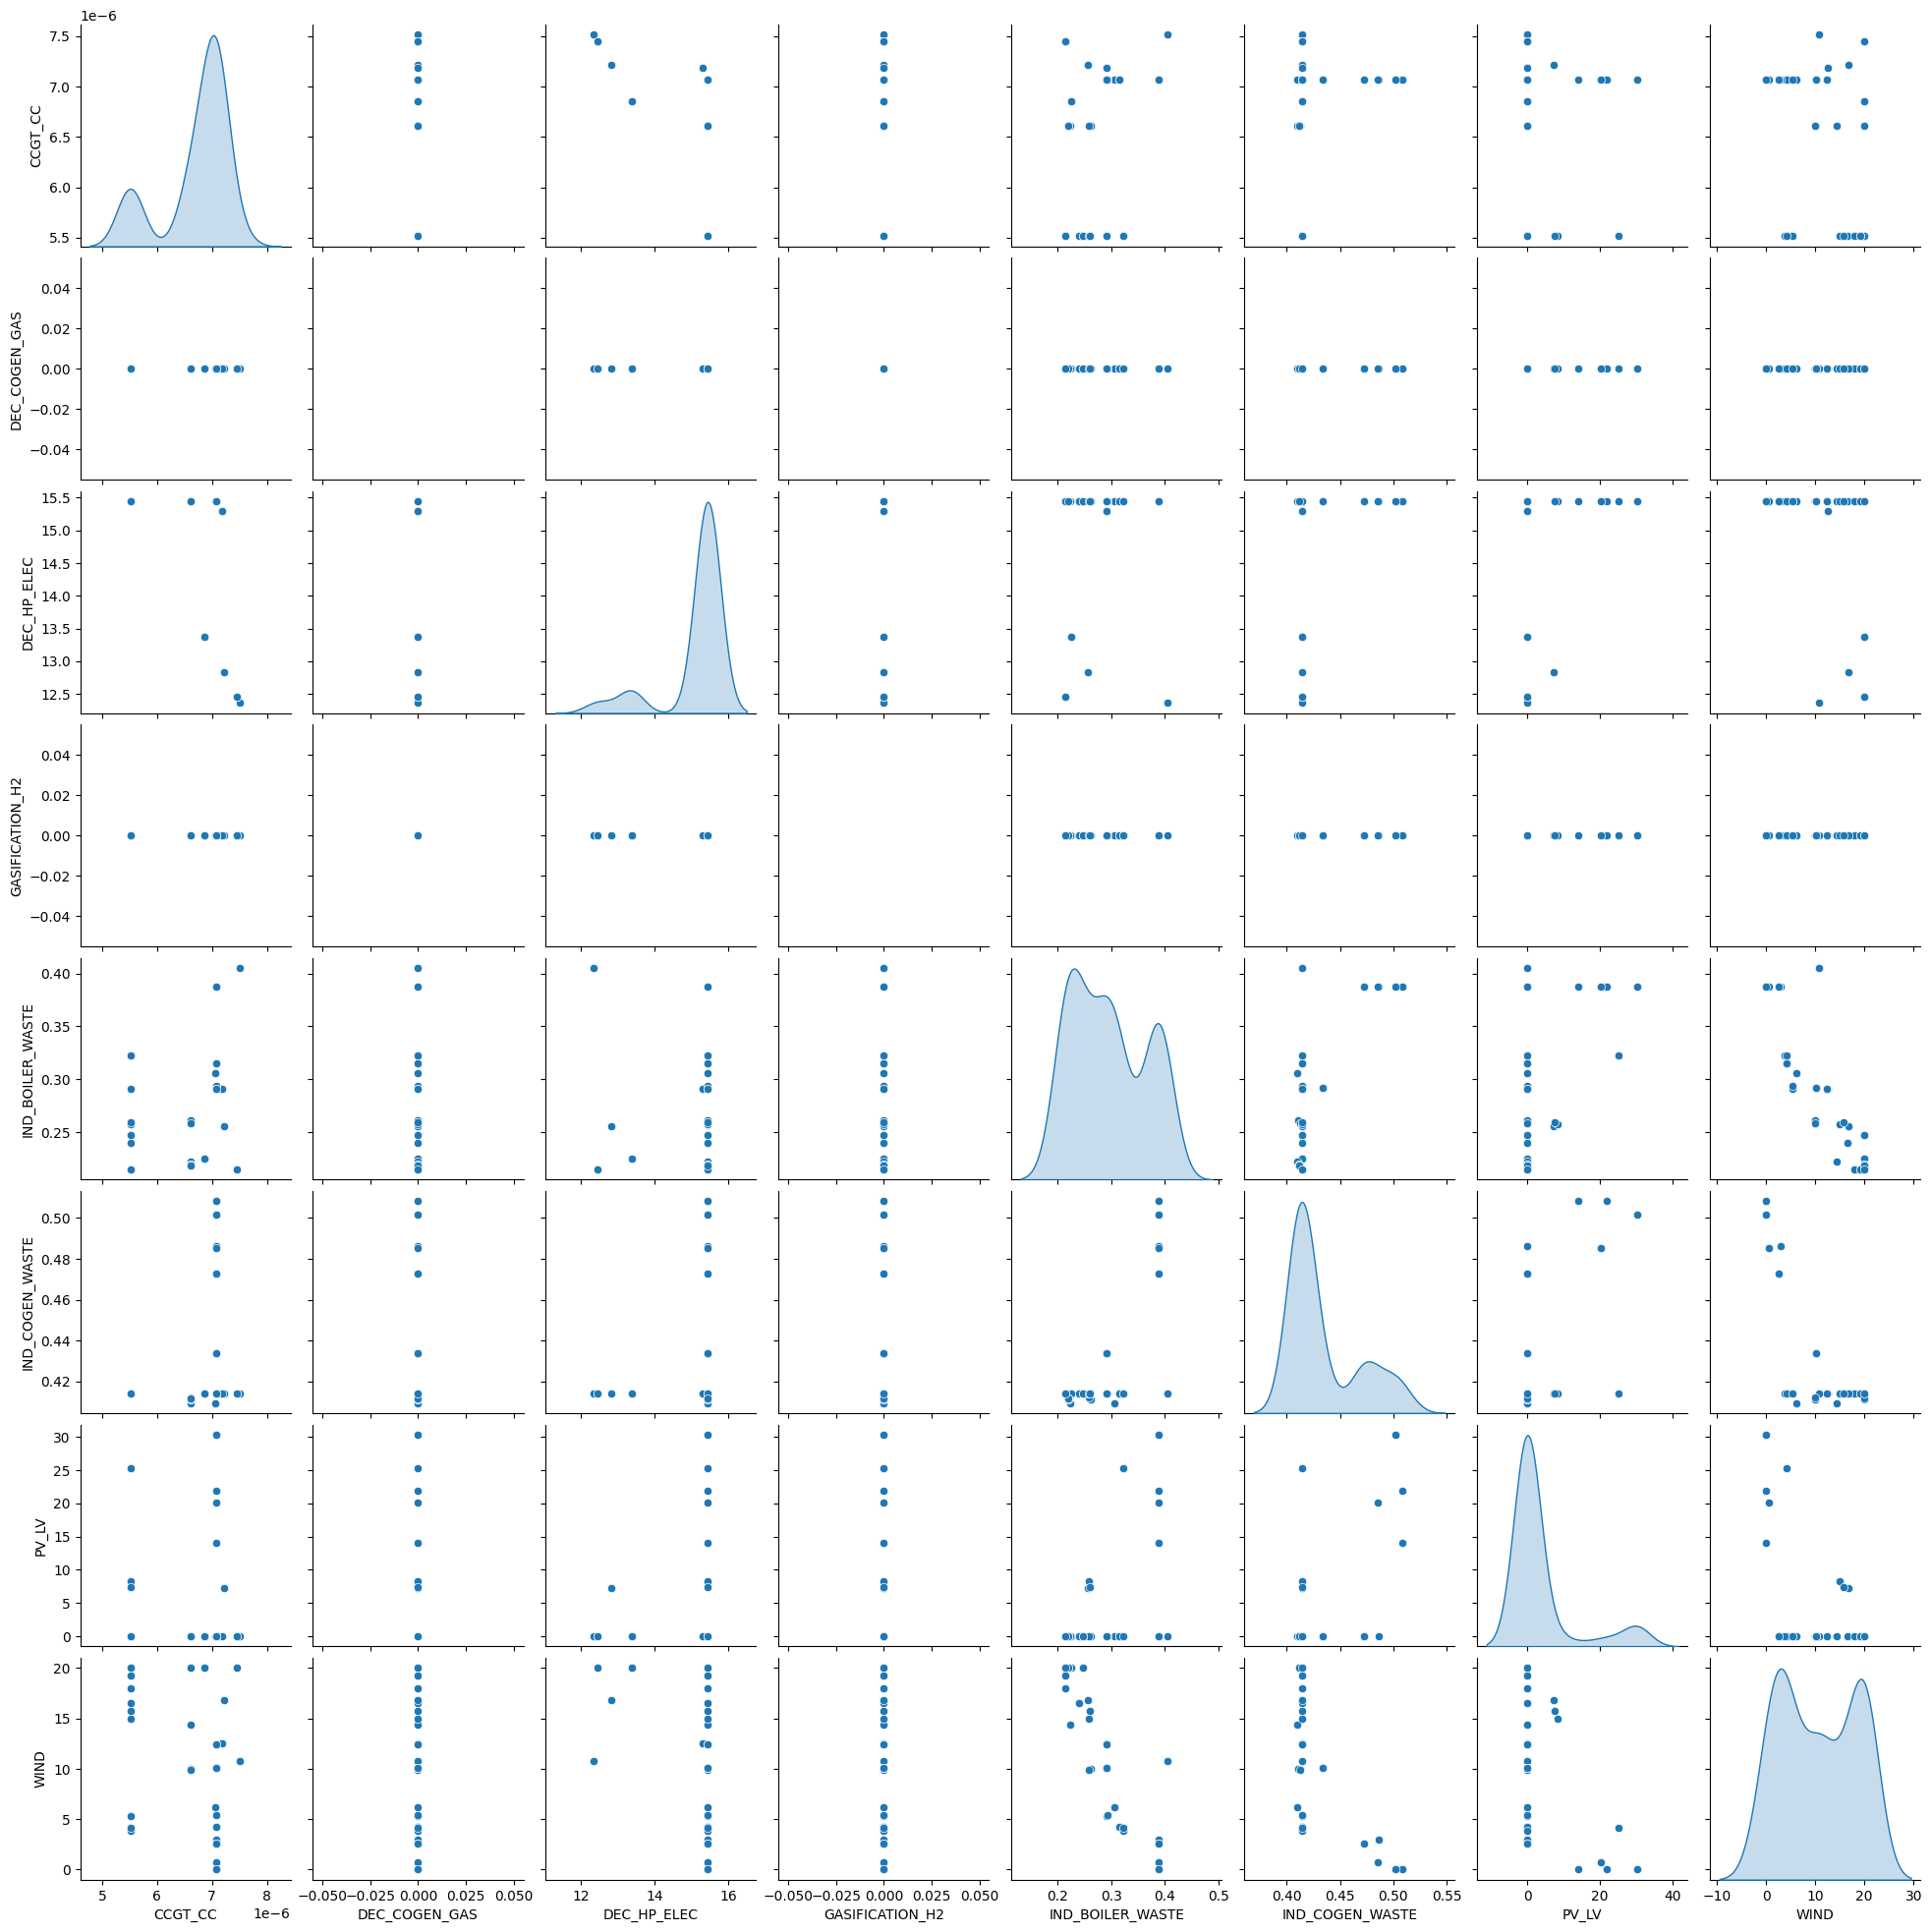

In [26]:
cols = ['CCGT_CC', 'DEC_COGEN_GAS', 'DEC_HP_ELEC', 'GASIFICATION_H2', 'IND_BOILER_WASTE', 'IND_COGEN_WASTE', 'PV_LV', 'WIND']
sns.pairplot(df_annual[cols].fillna(0), diag_kind="kde")



- We plot the distributions to understand how the uncertainty in investment costs affects the capacities of different technologies.

---

By following these steps, we perform an uncertainty analysis on the EnergyScope model by varying the investment costs of selected technologies. This approach allows us to understand the sensitivity of the energy system configuration to changes in key parameters.

**Note**: Ensure that all the necessary data files and dependencies are correctly set up in your environment. The computational time may vary depending on the number of optimizations and the complexity of the model.